In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import os
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib import cm
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [3]:
pwd

'/content'

In [4]:
# data_path = '/content/drive/MyDrive/NMA_DL_project/data_npy_format'
# model_path = '/content/drive/MyDrive/NMA_DL_project/models'

# data_path = '/Users/ag1880/Github_repos/augmented-manatees/data/data_npy_format'
#model_path = '/Users/ag1880/Github_repos/augmented-manatees/models'

data_path = '/content/drive/MyDrive/NMA-DL_project_data'
model_path = '/content/drive/MyDrive/NMA-DL_project_data'

if os.path.isdir(model_path):
  pass
else:
  os.mkdir(model_path)

In [5]:
def resize(X,xy=(200, 200)):
    reshape_im = []
    for n in range(X.shape[0]):
        reshape_im.append(cv2.resize(X[n,0],xy))
    reshape_im = np.array(reshape_im)
    reshape_im = np.array(np.expand_dims(reshape_im,axis=1))
    return reshape_im

# Load the images
orig_image = np.load(os.path.join(data_path,'images_without_HC_small.npy'))
orig_image = np.expand_dims(orig_image, axis=1)
image_resize = resize(orig_image,xy = (128,128))
print(orig_image.shape, image_resize.shape)

(5000, 1, 197, 197) (5000, 1, 128, 128)


In [6]:
# Transform (sharpen/high contrast) the images for training the GAN

data_transforms = transforms.Compose([
transforms.ToPILImage(),
# transforms.Scale(256),
transforms.ToTensor(),
transforms.RandomAdjustSharpness(sharpness_factor=10, p=1),
transforms.ColorJitter(brightness=2, contrast=0, saturation=0, hue=0)
])

image_trans = []
for i in range(image_resize.shape[0]):
  image_trans.append(data_transforms(image_resize[i][0]).numpy())
image_trans = np.array(image_trans)

In [13]:
# Convert images to 3 channel tensors

image_resize = torch.tensor(image_resize).type(torch.float32)
image_resize = image_resize.expand(image_resize.shape[0],3,128,128)

image_trans = torch.tensor(image_trans).type(torch.float32)
image_trans = image_trans.expand(image_trans.shape[0],3,128,128)

idx = torch.randperm(image_resize.shape[0])
image_shuffled = image_resize[idx]

print(image_trans.shape, image_resize.shape, image_shuffled.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


torch.Size([5000, 3, 128, 128]) torch.Size([5000, 3, 128, 128]) torch.Size([5000, 3, 128, 128])


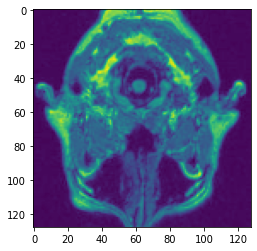

In [14]:
plt.imshow(image_resize[0][0].detach().cpu())
plt.show()

0
Check your dimensions!
torch.Size([3, 128, 128])


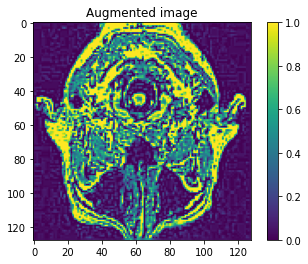

In [15]:
def plot_an_image(img,title="Augmented image"):
  if img.shape[0]==1:
    img = img[0]
  else:
    print("Check your dimensions!")
  print(img.shape)
  plt.imshow(img[0].detach().cpu())
  plt.title(title)
  plt.colorbar()
  plt.show()

idx = 0
print(idx)
plot_an_image(image_trans[idx],title="Augmented image")

In [16]:
norm_layer = nn.InstanceNorm2d
class ResBlock(nn.Module):
    def __init__(self, f):
        super(ResBlock, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(f, f, 3, 1, 1), norm_layer(f), nn.ReLU(),
                                  nn.Conv2d(f, f, 3, 1, 1))
        self.norm = norm_layer(f)
    def forward(self, x):
        return F.relu(self.norm(self.conv(x)+x))

class Generator(nn.Module):
    def __init__(self, f=64, blocks=9):
        super(Generator, self).__init__()
        layers = [nn.ReflectionPad2d(3),
                  nn.Conv2d(  3,   f, 7, 1, 0), norm_layer(  f), nn.ReLU(True),
                  nn.Conv2d(  f, 2*f, 3, 2, 1), norm_layer(2*f), nn.ReLU(True),
                  nn.Conv2d(2*f, 4*f, 3, 2, 1), norm_layer(4*f), nn.ReLU(True)]
        for i in range(int(blocks)):
            layers.append(ResBlock(4*f))
        layers.extend([
                nn.ConvTranspose2d(4*f, 4*2*f, 3, 1, 1), nn.PixelShuffle(2), norm_layer(2*f), nn.ReLU(True),
                nn.ConvTranspose2d(2*f,   4*f, 3, 1, 1), nn.PixelShuffle(2), norm_layer(  f), nn.ReLU(True),
                nn.ReflectionPad2d(3), nn.Conv2d(f, 3, 7, 1, 0),
                nn.Tanh()])
        self.conv = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.conv(x)

In [17]:
nc=3
ndf=64
class Discriminator(nn.Module):  
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc,ndf,4,2,1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf,ndf*2,4,2,1, bias=False),
            nn.InstanceNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf*2, ndf * 4, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16
            nn.Conv2d(ndf*4,ndf*8,4,1,1),
            nn.InstanceNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 15 x 15
            nn.Conv2d(ndf*8,1,4,1,1)
            # state size. 1 x 14 x 14
        )

    def forward(self, input):
        return self.main(input)

In [18]:
def LSGAN_D(real, fake):
  return (torch.mean((real - 1)**2) + torch.mean(fake**2))

def LSGAN_G(fake):
  return  torch.mean((fake - 1)**2)

In [19]:
G_A2B = Generator().to(device)
G_B2A = Generator().to(device)
D_A = Discriminator().to(device)
D_B = Discriminator().to(device)

# Initialize Loss function
criterion_Im = torch.nn.L1Loss() 

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Optimizers

In [24]:
def save_models(G_A2B, G_B2A, D_A, D_B, name):

  torch.save(G_A2B, model_path+name+"_G_A2B.pt")
  torch.save(G_B2A, model_path+name+"_G_B2A.pt")
  torch.save(D_A, model_path+name+"_D_A.pt")
  torch.save(D_B, model_path+name+"_D_B.pt")

def load_models( name):

  G_A2B=torch.load(model_path+name+"_G_A2B.pt")
  G_B2A=torch.load(model_path+name+"_G_B2A.pt")
  D_A=torch.load(model_path+name+"_D_A.pt")
  D_B=torch.load(model_path+name+"_D_B.pt")
  return G_A2B, G_B2A, D_A, D_B

#save_models(G_A2B, G_B2A, D_A, D_B, "test")
#G_A2B, G_B2A, D_A, D_B= load_models("test")

In [8]:
# # dataloader_zebra_train = torch.utils.data.DataLoader(dataset_zebra_train, batch_size=bs,
#                                         #  shuffle=True, num_workers=workers)

# from torch.utils.data import TensorDataset, DataLoader

# my_x = image_trans 
# my_y = images 

# tensor_x = torch.Tensor(my_x) # transform to torch tensor
# tensor_y = torch.Tensor(my_y)

# my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
# my_dataloader = DataLoader(my_dataset) # create your dataloader

# for  i,j in my_dataloader:
#   print(i[0].shape,j[0].shape)
#   break

In [9]:
image_trans.shape

(5000, 1, 128, 128)

In [10]:
image_resize.shape

torch.Size([5000, 1, 128, 128])

In [11]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

In [12]:
for i in batch(image_resize,8):
    img_batch = i
    break

im = torch.tensor(img_batch[0:2]).type(torch.float32)
im = im.expand(2,3,256,256).cuda()

print(im.shape)
im.dtype

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


RuntimeError: ignored

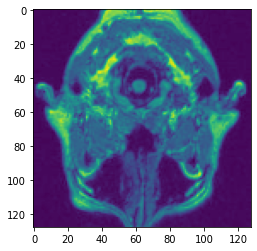

In [26]:
p = im[0,0].detach().cpu()
plt.imshow(p)

In [30]:
im.shape

torch.Size([2, 1, 128, 128])

In [29]:
im_gen = netG_A2B(im)

RuntimeError: ignored

In [28]:
plt.imshow(im_gen[0,0].detach().cpu())

NameError: ignored

In [19]:
# test = G_A2B(im)

In [20]:
# p = test[0,0].detach().cpu().numpy()
# p.shape

In [51]:
torch.cuda.empty_cache()
!nvidia-smi

Wed Aug 18 16:05:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    33W /  70W |   1698MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [20]:
def training(G_A2B, G_B2A, D_A, D_B,num_epochs,name,old = True):


  # Training Loop

  # Lists to keep track of progress
  img_list = []
  G_losses = []
  D_A_losses = []
  D_B_losses = []


  iters=0
  FDL_A2B = []
  FDL_B2A = []
  CL_A = []
  CL_B = []
  ID_B2A = []
  ID_A2B = []
  disc_A = []
  disc_B = []


  FDL_A2B_t = []
  FDL_B2A_t = []
  CL_A_t = []
  CL_B_t = []
  ID_B2A_t = []
  ID_A2B_t = []
  disc_A_t = []
  disc_B_t = []

  batch_size = 5
    
    
  print("Starting Training Loop...")
  # For each epoch
  for epoch in range(num_epochs):

    print('Epoch nr. = ',epoch)

    # For each batch
    for i,(img_batch, img_trans_batch) in enumerate(zip(batch(image_shuffled,batch_size),batch(image_trans,batch_size))):
        
        #torch.cuda.empty_cache()

        # Set model input
        a_real = torch.tensor(img_batch).to(device)
        b_real = torch.tensor(img_trans_batch).to(device)
      
        tensor_ones=torch.ones([a_real.shape[0],1,14,14]).cuda()
        tensor_zeros=torch.zeros([a_real.shape[0],1,14,14]).cuda()

        # Genrated images
        b_fake = G_A2B(a_real)
        a_rec = G_B2A(b_fake)
        a_fake = G_B2A(b_real)
        b_rec = G_A2B(a_fake)

       
        # Discriminator A
        optimizer_D_A.zero_grad()
        if((iters > 0 or epoch > 0) and old and iters % 3 == 0):
          rand_int = np.random.randint(5, old_a_fake.shape[0]-1)
          Disc_loss_A = LSGAN_D(D_A(a_real), D_A(old_a_fake[rand_int-5:rand_int].detach()))
          D_A_losses.append(Disc_loss_A.item())

        else:
          Disc_loss_A = LSGAN_D(D_A(a_real), D_A(a_fake.detach()))
          D_A_losses.append(Disc_loss_A.item())
        
        Disc_loss_A.backward()
        optimizer_D_A.step()

        
        # Discriminator B
        optimizer_D_B.zero_grad()
        if((iters > 0 or epoch > 0) and old and iters % 3 == 0):
          rand_int = np.random.randint(5, old_b_fake.shape[0]-1)
          Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(old_b_fake[rand_int-5:rand_int].detach()))
          D_B_losses.append(Disc_loss_B.item())
        else:
          Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(b_fake.detach()))
          D_B_losses.append(Disc_loss_B.item())

        Disc_loss_B.backward()
        optimizer_D_B.step()   

        # Generator

        optimizer_G_A2B.zero_grad()
        optimizer_G_B2A.zero_grad()


        # Fool discriminator
        Fool_disc_loss_A2B = LSGAN_G(D_B(b_fake))
        Fool_disc_loss_B2A = LSGAN_G(D_A(a_fake))

        # Cycle Consistency    both use the two generators
        Cycle_loss_A = criterion_Im(a_rec, a_real)*5
        Cycle_loss_B = criterion_Im(b_rec, b_real)*5

        # Identity loss
        Id_loss_B2A = criterion_Im(G_B2A(a_real), a_real)*10
        Id_loss_A2B = criterion_Im(G_A2B(b_real), b_real)*10

        # generator losses
        Loss_G = Fool_disc_loss_A2B+Fool_disc_loss_B2A+Cycle_loss_A+Cycle_loss_B+Id_loss_B2A+Id_loss_A2B
        G_losses.append(Loss_G)

        # Backward propagation
        Loss_G.backward()
        
        
        # Optimisation step
        optimizer_G_A2B.step()
        optimizer_G_B2A.step()

        FDL_A2B.append(Fool_disc_loss_A2B)
        FDL_B2A.append(Fool_disc_loss_B2A)
        CL_A.append(Cycle_loss_A)
        CL_B.append(Cycle_loss_B)
        ID_B2A.append(Id_loss_B2A)
        ID_A2B.append(Id_loss_A2B)
        disc_A.append(Disc_loss_A)
        disc_B.append(Disc_loss_B)

        if(iters == 0 and epoch == 0):
          old_b_fake = b_fake.clone()
          old_a_fake = a_fake.clone()
        elif (old_b_fake.shape[0] == batch_size*5 and b_fake.shape[0]==batch_size):
          rand_int = np.random.randint(5, 24)
          old_b_fake[rand_int-5:rand_int] = b_fake.clone()
          old_a_fake[rand_int-5:rand_int] = a_fake.clone()
        elif(old_b_fake.shape[0]< 25):
          old_b_fake = torch.cat((b_fake.clone(),old_b_fake))
          old_a_fake = torch.cat((a_fake.clone(),old_a_fake))

        iters += 1
        del img_batch, img_trans_batch, a_real, b_real, a_fake, b_fake


        if iters % 50 == 0:
      
          print('[%d/%d]\tFDL_A2B: %.4f\tFDL_B2A: %.4f\tCL_A: %.4f\tCL_B: %.4f\tID_B2A: %.4f\tID_A2B: %.4f\tLoss_D_A: %.4f\tLoss_D_A: %.4f'
                      % (epoch+1, num_epochs, Fool_disc_loss_A2B, Fool_disc_loss_B2A,Cycle_loss_A,Cycle_loss_B,Id_loss_B2A,
                          Id_loss_A2B, Disc_loss_A.item(), Disc_loss_B.item()))
        

    FDL_A2B_t.append(sum(FDL_A2B)/len(FDL_A2B))
    FDL_B2A_t.append(sum(FDL_B2A)/len(FDL_B2A))
    CL_A_t.append(sum(CL_A)/len(CL_A))
    CL_B_t.append(sum(CL_B)/len(CL_B))
    ID_B2A_t.append(sum(ID_B2A)/len(ID_B2A))
    ID_A2B_t.append(sum(ID_A2B)/len(ID_A2B))
    disc_A_t.append(sum(disc_A)/len(disc_A))
    disc_B_t.append(sum(disc_B)/len(disc_B))

    FDL_A2B = []
    FDL_B2A = []
    CL_A = []
    CL_B = []
    ID_B2A = []
    ID_A2B = []
    disc_B = []
    disc_A = []

    iters = 0             
    save_models(G_A2B, G_B2A, D_A, D_B, name)
    if (epoch % 5 == 0):
      plot_images_test(img_batch, img_trans_batch)
  return(FDL_A2B_t,FDL_B2A_t,CL_A_t,CL_B_t,ID_B2A_t,ID_A2B_t,disc_A_t,disc_B_t)

In [21]:
name="MRIcycleGAN"

epochs=50
netG_A2B, netG_B2A, netD_A, netD_B=G_A2B, G_B2A, D_A, D_B

optimizer_G_A2B = torch.optim.Adam(G_A2B.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_G_B2A = torch.optim.Adam(G_B2A.parameters(), lr=lr, betas=(beta1, 0.999))

optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(beta1, 0.999))

losses = training( netG_A2B, netG_B2A, netD_A, netD_B,epochs,name)


Starting Training Loop...
Epoch nr. =  0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[1/50]	FDL_A2B: 0.3655	FDL_B2A: 0.9146	CL_A: 173.0626	CL_B: 1.2989	ID_B2A: 346.1312	ID_A2B: 2.3921	Loss_D_A: 0.0778	Loss_D_A: 0.3857
[1/50]	FDL_A2B: 0.1346	FDL_B2A: 1.0048	CL_A: 127.8491	CL_B: 0.8044	ID_B2A: 255.6924	ID_A2B: 1.3405	Loss_D_A: 0.0365	Loss_D_A: 0.4248
[1/50]	FDL_A2B: 0.4769	FDL_B2A: 1.0223	CL_A: 179.8450	CL_B: 0.8775	ID_B2A: 359.6906	ID_A2B: 1.2465	Loss_D_A: 0.0172	Loss_D_A: 0.3763
[1/50]	FDL_A2B: 0.3714	FDL_B2A: 1.0114	CL_A: 147.2221	CL_B: 0.6532	ID_B2A: 294.4441	ID_A2B: 1.1619	Loss_D_A: 0.0086	Loss_D_A: 0.5083
[1/50]	FDL_A2B: 0.2376	FDL_B2A: 1.0210	CL_A: 168.9888	CL_B: 0.3508	ID_B2A: 337.9799	ID_A2B: 0.6425	Loss_D_A: 0.0092	Loss_D_A: 0.4701
[1/50]	FDL_A2B: 0.2699	FDL_B2A: 0.6834	CL_A: 105.8441	CL_B: 0.5286	ID_B2A: 211.6903	ID_A2B: 0.8470	Loss_D_A: 0.0776	Loss_D_A: 0.5950
[1/50]	FDL_A2B: 0.3411	FDL_B2A: 0.8418	CL_A: 102.8675	CL_B: 0.6935	ID_B2A: 205.7383	ID_A2B: 0.8547	Loss_D_A: 0.0339	Loss_D_A: 0.4550
[1/50]	FDL_A2B: 0.1597	FDL_B2A: 0.8628	CL_A: 160.6848	CL_B: 0.6393	ID

NameError: ignored

In [25]:
name="MRIcycleGAN"

save_models(G_A2B, G_B2A, D_A, D_B, name)